# Métodos de Aprendizaje no supervisado

In [1]:
import pandas as pd

df = pd.read_excel('../../res/tp4/acath.xlsx', sheet_name='acath')  # 3505 rows

df.head()

,sex,age,cad.dur,choleste,sigdz,tvdlm
0,0,73,132,268.0,1,1.0
1,0,68,85,120.0,1,1.0
2,0,54,45,NaN,1,0.0
3,1,58,86,245.0,0,0.0
4,1,56,7,269.0,0,0.0


In [2]:
negative = df[df.sigdz == 0]
positive = df[df.sigdz == 1]

print(f"Cantidad de filas negativas: {len(negative)}")
print(f"Cantidad de filas positivas: {len(positive)}")

# Se elige un subset de filas para igualar la proporción
positive = positive.sample(n=len(negative))

total = [negative, positive]
df = pd.concat(total)

Cantidad de filas negativas: 1170
Cantidad de filas positivas: 2334


In [3]:
df.head()

,sex,age,cad.dur,choleste,sigdz,tvdlm
3,1,58,86,245.0,0,0.0
4,1,56,7,269.0,0,0.0
11,0,35,44,257.0,0,0.0
12,1,69,10,NaN,0,0.0
20,1,52,30,240.0,0,0.0


In [4]:
import numpy as np

# Sanitize dataset
result_column = 'sigdz'
columns = ['sex', 'age', 'cad.dur', 'choleste', 'tvdlm']
numeric_columns = ['age', 'cad.dur', 'choleste']

# Replace numeric value for `sigdz` with logical value
# df.replace({result_column: {1: 'T', 0: 'F'}}, inplace=True)
# df.replace({'tvdlm': {1: 'T', 0: 'F'}}, inplace=True)
# df.replace({'sex': {1: 'F', 0: 'M'}}, inplace=True)

# Replace NaN occurrences with mean
for column in numeric_columns:
    df.replace({column: {np.nan: int(df[column].mean())}}, inplace=True)

df.head()

,sex,age,cad.dur,choleste,sigdz,tvdlm
3,1,58,86,245.0,0,0.0
4,1,56,7,269.0,0,0.0
11,0,35,44,257.0,0,0.0
12,1,69,10,227.0,0,0.0
20,1,52,30,240.0,0,0.0


## Regresión Logística

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

def train_model(data, fields, result_var, params=None):
    model = LogisticRegression()
    model.fit(data[fields], data[result_var])
    return model


model = train_model(train, numeric_columns, result_column)
print(f"sklearn Classes: {model.classes_}")
print(f"sklearn Coeficients: {model.coef_}")
print(f"sklearn Intercept b0: {model.intercept_}")

sklearn Classes: [0 1]
sklearn Coeficients: [[ 0.05119752 -0.00048085  0.00482125]]
sklearn Intercept b0: [-3.71377619]


In [8]:
predicted = model.predict(test[numeric_columns])

Población completa


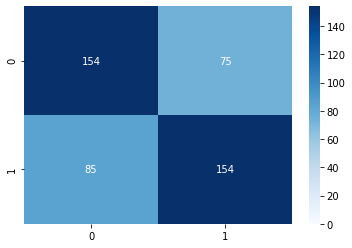

In [9]:
import seaborn as sns

def plot_confusion_matrix(data, result_var, predictions, title=None, ax=None):
    conf_mat = confusion_matrix(data[result_var], predictions)
    count_values = list(map(lambda x: sum(x), conf_mat))

    unique, counts = np.unique(np.array(data[result_var]), return_counts=True)
    count_labels = dict(zip(counts, unique))

    labels = []
    for value in count_values:
        labels.append(count_labels[value])

    if title is not None:
        print(title)

    if ax is None:
        sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, vmin=0)
    else:
        sns.heatmap(conf_mat, ax=ax, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, vmin=0)

plot_confusion_matrix(test, result_column, predicted, title='Población completa')

In [11]:
print(classification_report(test[result_column], predicted))

              precision    recall  f1-score   support

           0       0.64      0.67      0.66       229
           1       0.67      0.64      0.66       239

    accuracy                           0.66       468
   macro avg       0.66      0.66      0.66       468
weighted avg       0.66      0.66      0.66       468



#### Repetición del experimento usando librería statsmodels

In [12]:
import statsmodels.api as sm

def train_statsmodels_model(data, x1, result_var, params=None):
    model = sm.Logit(data[result_var], x1).fit()
    print(model.summary())
    return model

x1 = sm.add_constant(train[numeric_columns])
statsmodel = train_statsmodels_model(train, x1, result_column)

Optimization terminated successfully.
         Current function value: 0.659457
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  sigdz   No. Observations:                 1872
Model:                          Logit   Df Residuals:                     1868
Method:                           MLE   Df Model:                            3
Date:                Tue, 22 Jun 2021   Pseudo R-squ.:                 0.04858
Time:                        20:19:35   Log-Likelihood:                -1234.5
converged:                       True   LL-Null:                       -1297.5
Covariance Type:            nonrobust   LLR p-value:                 3.780e-27
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7139      0.394     -9.425      0.000      -4.486      -2.942
age            0.0512      0.

In [14]:
x2 = sm.add_constant(test[numeric_columns])
yhat = statsmodel.predict(x2)
predicted_2 = list(map(round, yhat))
print('Actual values', list(test[result_column].values))
print('statsmodels Predictions :', predicted_2)

Actual values [0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1

statsmodels Población completa


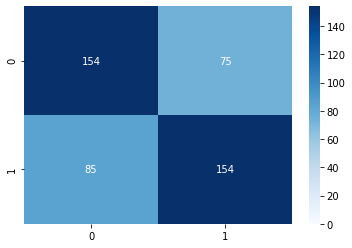

In [15]:
plot_confusion_matrix(test, result_column, predicted_2, title='statsmodels Población completa')

In [18]:
import math

def classify_with_regression(row, model):
    betas = model.params.values
    X = betas[0] + betas[1] * row[0] + betas[2] * row[1] + betas[3] * row[2]
    exp_X = math.exp(X)
    return exp_X / (1 + exp_X)

fila = (60, 199, 2)
proba = classify_with_regression(fila, statsmodel)
print(f"P(sigdz == 1) = {proba}")
print(f"Se podría afirmar que sigdz == {0 if proba < 0.5 else 1}")

P(sigdz == 1) = 0.3256309693331923
Se podría afirmar que sigdz == 0


### Regresión Logística por género

In [19]:
men = df[df.sex == 0]
women = df[df.sex == 1]

train_men, test_men = train_test_split(men, test_size=0.2)
train_women, test_women = train_test_split(women, test_size=0.2)

print(f'Hombres: {len(men)}\nMujeres: {len(women)}')

Hombres: 1471
Mujeres: 869


Optimization terminated successfully.
         Current function value: 0.567663
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  sigdz   No. Observations:                 1176
Model:                          Logit   Df Residuals:                     1172
Method:                           MLE   Df Model:                            3
Date:                Tue, 22 Jun 2021   Pseudo R-squ.:                  0.1284
Time:                        20:21:56   Log-Likelihood:                -667.57
converged:                       True   LL-Null:                       -765.88
Covariance Type:            nonrobust   LLR p-value:                 2.280e-42
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.4525      0.618    -10.438      0.000      -7.664      -5.241
age            0.0849      0.

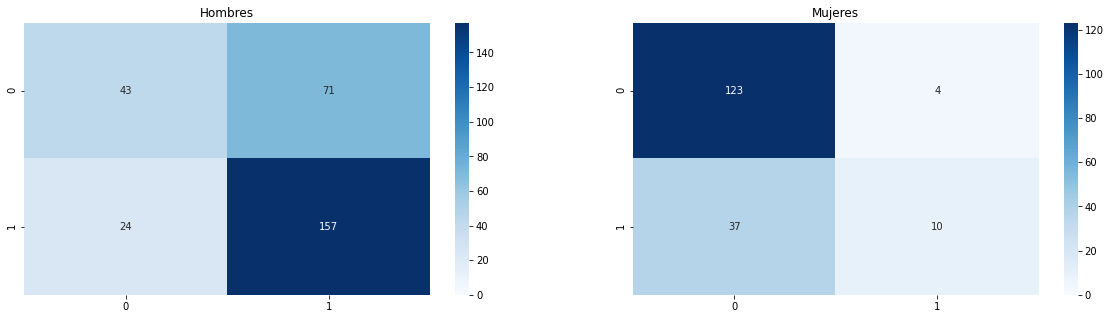

In [20]:
import matplotlib.pyplot as plt

x1_men = sm.add_constant(train_men[numeric_columns])
x1_women = sm.add_constant(train_women[numeric_columns])

model_men_2 = train_statsmodels_model(train_men, x1_men, result_column)
model_women_2 = train_statsmodels_model(train_women, x1_women, result_column)

x2_men = sm.add_constant(test_men[numeric_columns])
x2_women = sm.add_constant(test_women[numeric_columns])

yhat_men = model_men_2.predict(x2_men)
predicted_men_2 = list(map(round, yhat_men))
yhat_women = model_women_2.predict(x2_women)
predicted_women_2 = list(map(round, yhat_women))

tests = [test_men, test_women]
preds = [predicted_men_2, predicted_women_2]
titles = ['Hombres', 'Mujeres']

conf_mat_fig = plt.figure(figsize=(20,5))
i = 1
j = 2
k = 1
for test_specific, pred, title in zip(tests, preds, titles):
    mat_ax = conf_mat_fig.add_subplot(i, j, k)
    mat_ax.set_title(title)
    plot_confusion_matrix(test_specific, result_column, pred, ax=mat_ax)
    k += 1

## Agrupamiento Jerárquico

In [21]:
train_hc, test_hc = train_test_split(df, test_size=0.05)

In [22]:
def normalize_df(data):
    normalized_df = data.copy()
    for column in numeric_columns:
        column_min = min(normalized_df[column])
        column_max = max(normalized_df[column])
        #print(f"{column_min} {column_max}")
        normalized_df[column] = normalized_df[column].apply(lambda x: (x - column_min) / (column_max - column_min))

    #normalized_df.head()
    
    return normalized_df

In [23]:
def get_distance_matrix(data):
    distance_matrix = np.zeros((len(data), len(data)))
    num_norm_df = data[numeric_columns]
    for i in range(len(data)):
        row_i = num_norm_df.iloc[i].to_numpy()
        for j in range(len(data)):
            if i >= j:
                continue
            row_j = num_norm_df.iloc[j].to_numpy()
            dist = np.linalg.norm(row_i - row_j)
            distance_matrix[i][j] = distance_matrix[j][i] = dist

        #if i % 50 == 0:
        #    print(f"Processed {i} rows")
            
    return distance_matrix

In [25]:
# [Nivel, Grupos]
# Grupos = [[p1, p2, p13], [p4], [p5, p9], ...] # array de sets

np.set_printoptions(linewidth=120)

def get_basic_distance_between_groups(group_1, group_2, distance_matrix, operation):
    min_dist = None
    for point_1_index in group_1:
        for point_2_index in group_2:
            dist = distance_matrix[point_1_index][point_2_index]
            if min_dist is None or eval(f"{dist} {operation} {min_dist}"):
                min_dist = dist
    return min_dist

def get_average_distance_between_groups(group_1, group_2, distance_matrix):
    suma = 0
    for point_1_index in group_1:
        for point_2_index in group_2:
            suma += distance_matrix[point_1_index][point_2_index]
    return suma / (len(group_1) * len(group_2))

def get_centroid_distance_between_groups(group_1_index, group_2_index, centroids):
    return np.linalg.norm(centroids[group_1_index]["centroid"] - centroids[group_2_index]["centroid"])
    
def get_distance_between_groups(groups, group_1_index, group_2_index, mode, distance_matrix, centroids=None):
    group_1 = groups[group_1_index]
    group_2 = groups[group_2_index]
    if mode == "min":
        return get_basic_distance_between_groups(group_1, group_2, distance_matrix, "<")
    elif mode == "max":
        return get_basic_distance_between_groups(group_1, group_2, distance_matrix, ">")
    elif mode == "avg":
        return get_average_distance_between_groups(group_1, group_2, distance_matrix)
    elif mode == "ctr":
        return get_centroid_distance_between_groups(group_1_index, group_2_index, centroids)
    
    raise Exception("Invalid distance mode")

def hierarchical_clustering(data, mode, cluster_count, distance_matrix):
    levels = [[]]
    for i in range(len(data)):
        levels[0].append(set([i]))
    
    centroids = None # Array of centroid coordinates for each group
    if mode == "ctr":
        centroids = []
        for i in range(len(data[numeric_columns])):
            point = data[numeric_columns].iloc[i].to_numpy()
            centroids.append({"centroid": point, "points": np.array([point])})
    
    current_level = 0
    while len(levels[current_level]) > cluster_count:
        current_groups = levels[current_level]
        group_qty = len(levels[current_level])
        
        min_group_dist = None
        groups_to_merge = (None, None) # Indices
        
        for i in range(group_qty):
            for j in range(i + 1, group_qty):
                group_dist = get_distance_between_groups(current_groups, i, j, mode, distance_matrix, centroids)
                if (min_group_dist is None) or (group_dist < min_group_dist):
                    groups_to_merge = (i, j)
                    min_group_dist = group_dist

        group_to_merge_1 = current_groups[groups_to_merge[0]]
        group_to_merge_2 = current_groups[groups_to_merge[1]]
        
        levels.append(current_groups.copy())
        new_group = set()
        new_group.update(group_to_merge_2)
        new_group.update(group_to_merge_1)
        levels[current_level + 1].append(new_group)
        levels[current_level + 1].pop(max(groups_to_merge))
        levels[current_level + 1].pop(min(groups_to_merge))
        
        if centroids is not None: # Push new group's centroid based on previous 2 centroids
            centroid_dict_1 = centroids.pop(max(groups_to_merge))
            centroid_dict_2 = centroids.pop(min(groups_to_merge))
            merged_points = np.concatenate((centroid_dict_1["points"], centroid_dict_2["points"]), axis=0)
            new_centroid_dict = {"centroid": merged_points.mean(axis=0), "points": merged_points}
            centroids.append(new_centroid_dict)

        current_level += 1
        
        #if current_level % 25 == 0:
        #    print(f"Clusters merged: {current_level} - Distance between merged clusters was {min_group_dist}")
        
    return levels

In [26]:
from scipy import stats

def classify_clusters(data, clusters):
    if len(clusters) != 2:
        raise Exception("Invalid argument")
        
    cluster_1_rows = np.array(list(map(lambda x: data[result_column].iloc[x], clusters[0])))
    cluster_1_mode = stats.mode(cluster_1_rows)[0][0]
    cluster_2_rows = np.array(list(map(lambda x: data[result_column].iloc[x], clusters[1])))
    cluster_2_mode = stats.mode(cluster_2_rows)[0][0]
    
    return (cluster_1_mode, cluster_2_mode)

def get_clusters_centroids(train_data, clusters):
    if len(clusters) != 2:
        raise Exception("Invalid argument")
        
    centroids = []
    for cluster in clusters:
        cluster_points = np.array(list(map(lambda x: train_data[numeric_columns].iloc[x], cluster)))
        centroids.append(cluster_points.mean(axis=0))
    
    return centroids

def classify_with_centroids(centroids, cluster_classes, test_row):
    if len(centroids) != 2:
        raise Exception("Invalid argument")
    
    closest_centroid = None
    for index, centroid in enumerate(centroids):
        dist = np.linalg.norm(centroid - test_row.to_numpy())
        if closest_centroid is None or dist < closest_centroid[1]:
            closest_centroid = (index, dist)
    
    closest_centroid_class = cluster_classes[closest_centroid[0]]
    
    return closest_centroid_class

### Utilizando la Mínima como medida de similitud entre grupos

In [31]:
max_iter = 1000
iters = 0
clusters_min_dist = None
min_cluster_classes = None
# len(clusters_min_dist[-1][0]) < 5 or len(clusters_min_dist[-1][1]) < 5 or 
while clusters_min_dist is None or min_cluster_classes is None or (min_cluster_classes[0] == min_cluster_classes[1]) and iters < max_iter:
    train_hc, test_hc = train_test_split(df, train_size=0.01, test_size=0.5)
    normalized_train_df = normalize_df(train_hc)
    distance_matrix = get_distance_matrix(normalized_train_df)
    clusters_min_dist = hierarchical_clustering(normalized_train_df, "min", 2, distance_matrix)
    min_cluster_classes = classify_clusters(train_hc, clusters_min_dist[-1])
    iters += 1
print(clusters_min_dist[-1])
print(min_cluster_classes)

[{11, 14}, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22}]
(0, 1)


<AxesSubplot:>

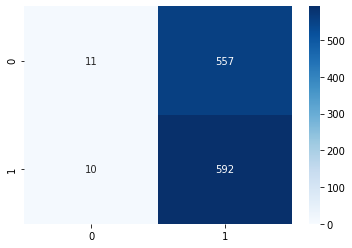

In [54]:
normalized_test_df = normalize_df(test_hc)
clusters_centroids = get_clusters_centroids(normalized_train_df, clusters_min_dist[-1])

# Armado de matriz de confusión (filas: valores reales; columnas: valores predictivos)
confusion_matrix = { 0: {}, 1: {} }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { 0: 0, 1: 0 }

for _, test_row in normalized_test_df.iterrows():
    real_class = test_row[result_column]
    predicted_class = classify_with_centroids(clusters_centroids, min_cluster_classes, test_row[numeric_columns])
    confusion_matrix[real_class][predicted_class] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g', vmin=0)

### Utilizando la Máxima como medida de similitud entre grupos

In [33]:
clusters_max_dist = hierarchical_clustering(normalized_train_df, "max", 2, distance_matrix)
print(clusters_max_dist[-1])

[{1, 18, 19, 5, 9, 12}, {0, 2, 3, 4, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 20, 21, 22}]


In [34]:
max_cluster_classes = classify_clusters(test_hc, clusters_max_dist[-1])
print(max_cluster_classes)

(0, 1)


<AxesSubplot:>

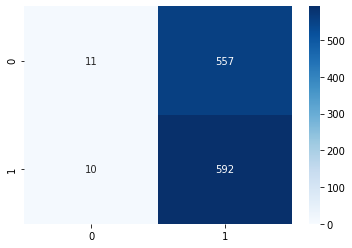

In [55]:
# Armado de matriz de confusión (filas: valores reales; columnas: valores predictivos)
confusion_matrix = { 0: {}, 1: {} }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { 0: 0, 1: 0 }

for _, test_row in normalized_test_df.iterrows():
    real_class = test_row[result_column]
    predicted_class = classify_with_centroids(clusters_centroids, max_cluster_classes, test_row[numeric_columns])
    confusion_matrix[real_class][predicted_class] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g', vmin=0)

### Utilizando el Promedio como medida de similitud entre grupos

In [36]:
clusters_avg_dist = hierarchical_clustering(normalized_train_df, "avg", 2, distance_matrix)
print(clusters_avg_dist[-1])

[{11, 14}, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22}]


In [37]:
avg_cluster_classes = classify_clusters(test_hc, clusters_avg_dist[-1])
print(avg_cluster_classes)

(0, 1)


<AxesSubplot:>

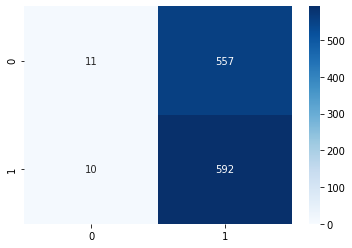

In [56]:
# Armado de matriz de confusión (filas: valores reales; columnas: valores predictivos)
confusion_matrix = { 0: {}, 1: {} }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { 0: 0, 1: 0 }

for _, test_row in normalized_test_df.iterrows():
    real_class = test_row[result_column]
    predicted_class = classify_with_centroids(clusters_centroids, avg_cluster_classes, test_row[numeric_columns])
    confusion_matrix[real_class][predicted_class] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g', vmin=0)

### Utilizando el Centroide como medida de similitud entre grupos

In [40]:
clusters_ctr_dist = hierarchical_clustering(normalized_train_df, "ctr", 2, distance_matrix)
print(clusters_ctr_dist[-1])

[{11, 14}, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22}]


In [41]:
ctr_cluster_classes = classify_clusters(test_hc, clusters_ctr_dist[-1])
print(ctr_cluster_classes)

(0, 1)


<AxesSubplot:>

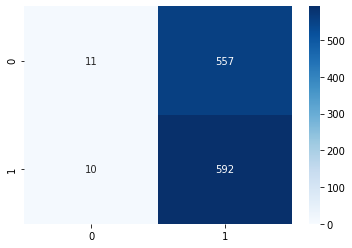

In [57]:
# Armado de matriz de confusión (filas: valores reales; columnas: valores predictivos)
confusion_matrix = { 0: {}, 1: {} }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { 0: 0, 1: 0 }

for _, test_row in normalized_test_df.iterrows():
    real_class = test_row[result_column]
    predicted_class = classify_with_centroids(clusters_centroids, ctr_cluster_classes, test_row[numeric_columns])
    confusion_matrix[real_class][predicted_class] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g', vmin=0)

## K-medias

In [52]:
rng = np.random.default_rng()

# Update centroids based on points in the cluster
def update_centroids(data, classes):
    for clase in classes.values():
        if clase["changed"]:
            clase["centroid"] = np.array(list(map(lambda x: data.iloc[x], clase["indices"]))).mean(axis=0)
            clase["changed"] = False

def K_means(data, K=2):
    classes = {i: {"indices": set(), "centroid": np.zeros(len(numeric_columns)), "changed": True} for i in range(1, K+1)}
    
    # Set random clusters for every data point
    random_classes = rng.integers(1, K+1, size=len(data))
    for index, point_class in enumerate(random_classes):
        classes[point_class]["indices"].add(index)
    
    # Iterate until no changes are made in cluster
    while any(map(lambda x: x["changed"], classes.values())):
        update_centroids(data, classes)

        changes = []
        for clase, clase_value in classes.items():
            for point_index in clase_value["indices"]:
                point = data.iloc[point_index]
                
                # Get closest cluster based on distance to cluster centroids
                closest_class = (clase, np.linalg.norm(point - clase_value["centroid"]))
                for other_class, other_class_value in classes.items():
                    if clase == other_class:
                        continue

                    other_centroid = other_class_value["centroid"]
                    other_centroid_dist = np.linalg.norm(point - other_centroid)

                    if other_centroid_dist < closest_class[1]:
                        closest_class = (other_class, other_centroid_dist)

                if closest_class[0] != clase:
                    # Record belongs to another cluster, save for later update
                    changes.append({"old_cluster": clase, "new_cluster": closest_class[0], "point_index": point_index})

        # Update clusters
        for change in changes:
            old_cluster = classes[change["old_cluster"]]
            new_cluster = classes[change["new_cluster"]]
            old_cluster["indices"].remove(change["point_index"])
            new_cluster["indices"].add(change["point_index"])
            old_cluster["changed"] = new_cluster["changed"] = True
            
        print(f"Cluster changes processed: {len(changes)}")

    return classes

def classify_K_means(data, clusters):
    modes = []
    for cluster in clusters.values():
        cluster_rows = np.array(list(map(lambda x: data[result_column].iloc[x], cluster["indices"])))
        cluster_mode = stats.mode(cluster_rows)[0][0]
        modes.append(cluster_mode)
        
    return modes

def get_W(data, cluster):
    W = 0
    cluster_indices = list(cluster["indices"])
    for i in range(len(cluster_indices)):
        point_1 = data.iloc[cluster_indices[i]]
        for j in range(i+1, len(cluster_indices)):
            point_2 = data.iloc[cluster_indices[j]]
            W += sum(map(lambda x: (x[0] - x[1])**2, zip(point_1, point_2)))
    return W / len(cluster_indices)

def K_means_best(data, iterations=10, K=2):
    min_W_sum = None
    for i in range(iterations):
        sample, test = train_test_split(data, test_size=0.3)
        K_means_clusters = K_means(sample, K)
        W_sum = 0
        
        # Calculate the sum of W of each cluster
        for current_K in range(1, K+1):
            W_sum += get_W(sample, K_means_clusters[current_K])
        
        # Get the best clusters based on minimum W sum
        if min_W_sum is None or W_sum < min_W_sum[1]:
            min_W_sum = (K_means_clusters, W_sum, sample, test)
            
        print(f"Finished iteration {i+1} - W sum: {W_sum}")
            
    return min_W_sum

def classify_K_means_best(data, sample, clusters):
    modes = []
    for cluster in clusters.values():
        # sample:
        # index | cad.dur   | age | ...
        # 1774  | 0.6       | 0.6 | ...
        # 3297  | 0.4       | 0.5 | ...
        #
        # data:
        # index | sex | cad.dur | ... | sigdz
        # 1774  | 1   | 0.6     | ... | 0
        # 3297  | 0.4 | 0.5    | ...  | 1
        #
        # Based on index in sample (1774), look for result column (sigdz) in entire data set - subsample does not have column sigdz and has less rows
        cluster_rows = np.array(list(map(lambda x: data[result_column].loc[sample.index[x]], cluster["indices"])))
        cluster_mode = stats.mode(cluster_rows)[0][0]
        modes.append(cluster_mode)
        
    return modes

In [44]:
# Use balanced dataset, without dividing into training and testing
complete_normalized_df = df.copy()
for column in numeric_columns:
    column_min = min(complete_normalized_df[column])
    column_max = max(complete_normalized_df[column])
    complete_normalized_df[column] = complete_normalized_df[column].apply(lambda x: (x - column_min) / (column_max - column_min))

complete_numeric_norm_df = complete_normalized_df[numeric_columns]

In [46]:
complete_normalized_df.head()

,sex,age,cad.dur,choleste,sigdz,tvdlm
3,1,0.640625,0.212871,0.340637,0,0.0
4,1,0.609375,0.017327,0.388446,0,0.0
11,0,0.281250,0.108911,0.364542,0,0.0
12,1,0.812500,0.024752,0.304781,0,0.0
20,1,0.546875,0.074257,0.330677,0,0.0


In [47]:
K_means_clusters = K_means(complete_numeric_norm_df, 2)

Cluster changes processed: 1161
Cluster changes processed: 261
Cluster changes processed: 131
Cluster changes processed: 58
Cluster changes processed: 58
Cluster changes processed: 75
Cluster changes processed: 68
Cluster changes processed: 69
Cluster changes processed: 48
Cluster changes processed: 40
Cluster changes processed: 33
Cluster changes processed: 40
Cluster changes processed: 24
Cluster changes processed: 16
Cluster changes processed: 18
Cluster changes processed: 13
Cluster changes processed: 12
Cluster changes processed: 9
Cluster changes processed: 6
Cluster changes processed: 4
Cluster changes processed: 7
Cluster changes processed: 2
Cluster changes processed: 0


In [48]:
classify_K_means(complete_normalized_df, K_means_clusters)

[0, 1]

In [50]:
get_W(complete_numeric_norm_df, K_means_clusters[1])

25.38733341742344

In [51]:
get_W(complete_numeric_norm_df, K_means_clusters[2])

49.852593692117885

Run K-means algorithm multiple times and keep the data that gives the minimum W(C_k) sum

In [70]:
K_means_best_clusters, min_W_sum, K_means_best_sample, K_means_best_test = K_means_best(complete_numeric_norm_df, 10, 2)

Cluster changes processed: 812
Cluster changes processed: 78
Cluster changes processed: 33
Cluster changes processed: 17
Cluster changes processed: 9
Cluster changes processed: 7
Cluster changes processed: 10
Cluster changes processed: 7
Cluster changes processed: 5
Cluster changes processed: 3
Cluster changes processed: 1
Cluster changes processed: 1
Cluster changes processed: 0
Finished iteration 1 - W sum: 51.98275002585898
Cluster changes processed: 810
Cluster changes processed: 165
Cluster changes processed: 43
Cluster changes processed: 12
Cluster changes processed: 5
Cluster changes processed: 3
Cluster changes processed: 3
Cluster changes processed: 1
Cluster changes processed: 1
Cluster changes processed: 1
Cluster changes processed: 0
Finished iteration 2 - W sum: 53.0193345589859
Cluster changes processed: 826
Cluster changes processed: 165
Cluster changes processed: 116
Cluster changes processed: 76
Cluster changes processed: 41
Cluster changes processed: 17
Cluster change

In [71]:
K_means_best_classes = classify_K_means_best(complete_normalized_df, K_means_best_sample, K_means_best_clusters)

In [72]:
K_means_best_classes

[0, 1]

In [73]:
k_means_clusters_centroids = list(map(lambda x: x["centroid"], K_means_best_clusters.values()))
print(k_means_clusters_centroids)

[array([0.42104143, 0.04737247, 0.30186858]), array([0.65905713, 0.15083969, 0.30838074])]


<AxesSubplot:>

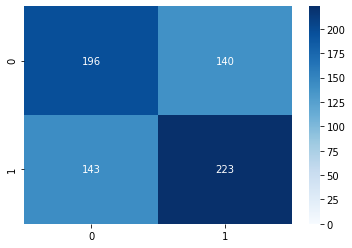

In [74]:
# Armado de matriz de confusión (filas: valores reales; columnas: valores predictivos)
confusion_matrix = { 0: {}, 1: {} }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { 0: 0, 1: 0 }

for idx, test_row in K_means_best_test.iterrows():
    real_class = complete_normalized_df[result_column].loc[idx]
    predicted_class = classify_with_centroids(k_means_clusters_centroids, K_means_best_classes, test_row[numeric_columns])
    confusion_matrix[real_class][predicted_class] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g', vmin=0)

### Redes de Kohonen

In [75]:
import numpy as np

def update_R(epoch, max_epochs, initial_R):
    return (max_epochs - epoch) * initial_R / max_epochs

# Usamos la distancia euclidea como medida de similitud para saber cual es la neurona ganadora
def euclidean_distance(w, xp):
    return np.linalg.norm(w - xp)

# Actualizacion de los pesos para la neurona ganadora para el ejemplo de entrenamiento
def update_w_winning_neuron(w, n, xp):
    delta_w = n * (xp - w)
    return w + delta_w

# Actualizacion de pesos para una neurona que esta en el vecindario de la neurona ganadora
def update_w_neighbour(w, n, xp, d, R):
    V = math.exp(-2 * d / R)
    delta_w = V * n * (xp - w)
    return w + delta_w
    
def update_learning_factor(epoch, max_epochs):
    return 0.1 * (1 - (epoch / max_epochs))

def update_neighbours(matrix, coords, R, k, n, xp):
    for i in range(k):
        for j in range(k):
            dist = np.linalg.norm(np.array([i, j]) - np.array([coords[0], coords[1]]))
            if (dist <= R):
                V = math.exp(-2 * dist / R)
                delta_w = V * n * (xp - matrix[i][j])
                matrix[i][j] += delta_w
    
            
            
def get_winning_neuron(matrix, xp, k):
    min_dist = None
    min_coords = None
    for i in range(k):
        for j in range(k):
            dist = euclidean_distance(matrix[i][j], xp)
            if min_dist is None or dist < min_dist:
                min_dist = dist
                min_coords = (i, j)
    return min_coords

In [78]:
# Crear una matriz de [K x K] para la capa de salida
# en cada posicion i,j hay un vector w con n pesos (dim de la cantidad de atributos
# de un ejemplo del dataset)

def train_kohonen(data, k=20, max_epochs=500):
    R = k
    epoch = 0
    n = 0.1
    # Inicializar los pesos con ~ U(-1, 1)
    matrix = [[rng.uniform(1, -1, len(numeric_columns)) for x in range(k)] for y in range(k)]
    
    while epoch < max_epochs:
        
        for index, row in data.iterrows():
            xp = row.to_numpy()
            coords = get_winning_neuron(matrix, xp, k)
            winning_w = matrix[coords[0]][coords[1]]
            matrix[coords[0]][coords[1]] = update_w_winning_neuron(winning_w, n, xp)
            update_neighbours(matrix, coords, R, k, n, xp)
        
        epoch += 1
        R = update_R(epoch, max_epochs, k)
        n = update_learning_factor(epoch, max_epochs)
        if epoch % 50 == 0:
            print(f"Epoch {epoch}")
        
    return matrix

In [79]:
def create_count_matrix(data, matrix):
    k = len(matrix)
    count_matrix = [[[0, 0] for x in range(k)] for y in range(k)]
    for index, row in data.iterrows():
        xp = row[numeric_columns].to_numpy()
        coords = get_winning_neuron(matrix, xp, k)
        count_matrix[coords[0]][coords[1]][int(row[result_column])] += 1
        
    return count_matrix
    
    
def classify_kohonen(data, matrix):
    k = len(matrix)
    class_matrix = [[None for x in range(k)] for y in range(k)]
    count_matrix = create_count_matrix(data, matrix)
    for i in range(k):
        for j in range(k):
            if count_matrix[i][j][0] == 0 and count_matrix[i][j][1] == 0:
                class_matrix[i][j] = None
            elif count_matrix[i][j][0] >= count_matrix[i][j][1]:
                class_matrix[i][j] = 0
            else: 
                 class_matrix[i][j] = 1
    
    return class_matrix
            

In [80]:
ranged_df = df.copy()
for column in numeric_columns:
    mean = ranged_df[column].mean()
    std = ranged_df[column].std()
    ranged_df[column] = ranged_df[column].apply(lambda x: (x - mean) / std)

train_kohonen_df, test_kohonen_df = train_test_split(ranged_df, test_size=0.2)

kohonen_matrix = train_kohonen(train_kohonen_df[numeric_columns], k=4, max_epochs=500)

tagged_neurons = classify_kohonen(train_kohonen_df, kohonen_matrix)

print(tagged_neurons)

Epoch 50
Epoch 100
Epoch 150
Epoch 200
Epoch 250
Epoch 300
Epoch 350
Epoch 400
Epoch 450
Epoch 500
[[0, 0, 1, 1], [0, 0, 1, 1], [1, 0, 1, 0], [1, 1, 1, 1]]


<AxesSubplot:>

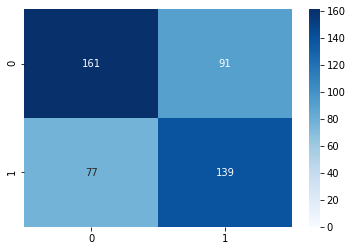

In [81]:
# Armado de matriz de confusión (filas: valores reales; columnas: valores predictivos)
confusion_matrix = { 0: {}, 1: {} }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { 0: 0, 1: 0 }

for index, row in test_kohonen_df.iterrows():
    
    real_class = row[result_column]
    coords = get_winning_neuron(kohonen_matrix, row[numeric_columns].to_numpy(), len(kohonen_matrix))
    predicted_class = tagged_neurons[coords[0]][coords[1]]
    confusion_matrix[real_class][predicted_class] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g', vmin=0)